#### Imports

In [58]:
!ls

MURA-v1.1  sample_data


In [0]:
# -*- coding: utf-8 -*-
# !wget -c https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
# !unzip MURA-v1.1.zip
# !rm MURA-v1.1.zip
# !ls

In [0]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import keras
pd.options.display.max_colwidth = 100
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetLarge
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import MobileNet
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.metrics import binary_accuracy, binary_crossentropy
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image as k_im_prep
from keras.models import Model
from keras import backend as K
from keras.models import Sequential

**Data Reading**

In [0]:
def paths_n_labels(csv,str_limp):
    #make dataframe
    studies=pd.read_csv(csv, sep=',',header=None)
    #separate study paths and labels of given limp from those of other limps
    limp_studies=studies[studies[0].str.contains(str_limp)==True]
    #make it a numpy
    limp_studies=np.array(limp_studies)
    #limp study folder paths
    limp_paths=[]
    #labels of given limp
    limp_labels=[]
    for i in tqdm( range(limp_studies.shape[0]) ):
        study_path=limp_studies[i][0]
        study_label=limp_studies[i][1]
        study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
        for image in study_files:
            limp_paths.append(study_path + image)
            limp_labels.append(study_label)

    limp_paths=np.array(limp_paths)
    limp_labels=np.array(limp_labels)

    return limp_paths,limp_labels

In [0]:
#general function with options for wrist data case, only set wrist_train=True in the case of wrist training data only
#for all other limps and for validation data even that of wrist just pass the paths
#targ_size is image resizing with default(224,224)
#preprocess flag is for using keras preprocessing for images or just resizing
def read_images(paths ,targ_size= (224, 224), wrist_train=False, preprocess=False):
    images=[]
    #load any limp images
    if(not wrist_train):
        for path in tqdm(paths):
            img=k_im_prep.load_img(path, target_size=targ_size)
#             img = np.stack((img,)*3, axis=-1)
            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))
    #special case for wrist train corrupted data       
    else:
        #did this because it gave an error at sample  5307 or near it if took all
        sample_e=5307
        sample_s2=5339
        images=[]
        for path in tqdm(paths[:sample_e]):
            img=k_im_prep.load_img(path, target_size=targ_size)
#             img = np.stack((img,)*3, axis=-1)

            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))

        #new start
        for path in tqdm(paths[sample_s2:]):
            img=k_im_prep.load_img(path, target_size=targ_size)
#             img = np.stack((img,)*3, axis=-1)

            if(preprocess):
                img = k_im_prep.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                images.append(np.array(img)[0])
            else:
              images.append(np.array(img))
    
    
    #making it a numpy array instead of python list
    return (np.array(images))
  

def wrist_labels(labels):
  sample_e=5307
  sample_s2=5339
  return np.hstack( [ labels[:sample_e], labels[sample_s2:] ])


In [0]:
train_studies='MURA-v1.1/train_labeled_studies.csv'
valid_studies='MURA-v1.1/valid_labeled_studies.csv'

In [64]:
#training images paths and labels
#starting with wrist data
train_paths,train_labels=paths_n_labels(train_studies,"WRIST")
#data bias : train
print("0 normal, 1 abnormal")
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

100%|██████████| 3460/3460 [00:00<00:00, 20646.08it/s]

0 normal, 1 abnormal
{0: 5769, 1: 3987}


In [0]:
# print("0 normal, 1 abnormal")
# unique, counts = np.unique(valid_labels, return_counts=True)
# print(dict(zip(unique, counts)))

### Model

In [0]:
def make_FT_model(base=1, imagenet=True, freeze_all=True, add_denses=True):
  
  #weights of pretrained model
  if (imagenet==True):
    w='imagenet'
  else:
    w=None
  
  #initializing pretrained model
  if (base==0):
    base_model = MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 1):
    base_model = DenseNet169(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 2):
    base_model = InceptionV3(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 3):
    base_model = ResNet50(input_shape= (224, 224, 3),weights=w, include_top=False)   
  elif (base == 4):
    base_model = NASNetLarge(input_shape= (224, 224, 3),weights=w, include_top=False)
    
 
  if (freeze_all):
    #freeze layers of densenet
    for layer in base_model.layers:
      layer.trainable= False 
  
  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  
  if(add_denses):
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
  else:
    # just feature extractor
    model = Model(inputs=base_model.input, output=x)
  
  
  return model

In [0]:
 def images_n_labels(limp): 
  
  print("\nreading studies of "+ limp + "\n")
  print(train_studies)
  train_paths,train_labels=paths_n_labels(train_studies,limp)
  valid_paths,valid_labels=paths_n_labels(valid_studies,limp)
  
  print(train_labels.shape)
  print(valid_labels.shape)
  print("reading "+ limp + " training images")
  if (limp == "WRIST"):
    train_labels=wrist_labels(train_labels) #for wrist reading problem
    train_imgs= read_images(train_paths,preprocess=True, wrist_train=True)
    
  else:
    train_imgs= read_images(train_paths,preprocess=True, wrist_train=False)
  print(train_imgs.shape)  
  print("reading "+ limp + " validation images")
  valid_imgs= read_images(valid_paths,preprocess=True)
  
  print("Training data shape is ",train_imgs.shape,train_labels.shape) 
  print("Validation data shape is" ,valid_imgs.shape,valid_labels.shape)

  
  return train_imgs, train_labels, valid_imgs, valid_labels

**The  Generator**




In [0]:
datagen = ImageDataGenerator(  rescale=1./255,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest')

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : return: Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
  
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
#     image=normalize(image)
    assert((titles is None)or (len(images) == len(titles)))
    n_images = 5
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
            
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()



In [0]:
def show_images_from_data_gen(datagen):
  datagen.fit(valid_imgs)
  
  max_num_iterations=1
  num_iterations=0
  
  for X_batch, y_batch in datagen.flow(valid_imgs,valid_labels,batch_size=10):
    if num_iterations >= max_num_iterations:
      break
    
    for i in range(0,9):
      plt.subplot(330+1+i)
      X_batch[i]=normalize(X_batch[i])
      plt.imshow(X_batch[i],cmap=plt.get_cmap('gray'))
    
    plt.show()
    
    num_iterations +=1

  2%|▏         | 20/1272 [00:00<00:06, 196.94it/s]


reading studies of HUMERUS

MURA-v1.1/train_labeled_studies.csv
(1272,)
(288,)
reading HUMERUS training images


  8%|▊         | 23/288 [00:00<00:01, 227.62it/s]

(1272, 224, 224, 3)
reading HUMERUS validation images


100%|██████████| 288/288 [00:01<00:00, 182.64it/s]


Training data shape is  (1272, 224, 224, 3) (1272,)
Validation data shape is (288, 224, 224, 3) (288,)
our next stop is error


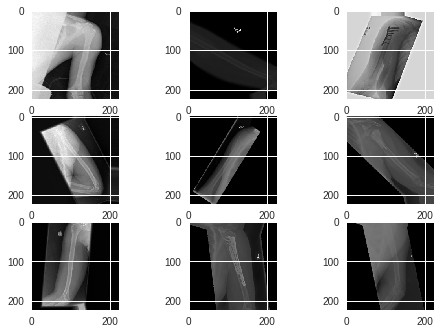

our next stop is runtime dying


In [57]:
# read_single_img = image.load_img("MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png", target_size=(224, 224))
# # img=normalize(img)
# # plt.imshow(img)

# # x_augmented =datagen.flow(img, label, batch_size=4)
# # print("our next stop is runtime dying")
# # plot_images(x_augmented, "Augmented Images")

# train_imgs, train_labels, valid_imgs, valid_labels= images_n_labels("HUMERUS")
# print("our next stop is error")
# show_images_from_data_gen(datagen)
# x_augmented =datagen.flow(valid_imgs, valid_labels, batch_size=4)
# print("our next stop is runtime dying")
# # plot_images(x_augmented, "Augmented Images")

### Generalizing over all limps

In [0]:
limps=["SHOULDER", "WRIST", "FINGER", "ELBOW", "HUMERUS", "HAND", "FOREARM"]

batch_aug_size=128
#pass to model list of limps because if wanted to train on less
#function outputs a dictionary or dataframe has train and val accuracies for each limp using a chosen model

def evaluate_limps(model_no=2, imagenet=True, freeze_all=False,v=1 , limps=limps, augment=False):
  accuracies={}
  for limp in limps:
    #print("reading "+ limp + " images\n")
    train_imgs, train_labels, valid_imgs, valid_labels= images_n_labels(limp)
    print("making model")
    model=make_FT_model(base= model_no, imagenet=False, freeze_all=False, add_denses=True)
    print("compiling")
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    ##############################################################
    
    if(augment): #dataaugmentation model fitting
      print("Augmenting Input data")
      # # compute quantities required for featurewise normalization
      # # (std, mean, and principal components if ZCA whitening is applied)

      datagen.fit(train_imgs)
      model.fit_generator(datagen.flow(train_imgs, train_labels, batch_size=batch_aug_size),
                    steps_per_epoch=len(train_imgs) / (batch_aug_size/8), epochs=5,use_multiprocessing=False,workers=6,validation_data=(valid_imgs, valid_labels))
      print("training augmentation calculations for "+ limp)

      loss_tr, accuracy_tr =model.evaluate_generator(datagen.flow(train_imgs,train_labels), use_multiprocessing=True,steps=len(valid_imgs) / batch_aug_size)
                                                     
      print("calculating validation augmentation loss for "+ limp)
                                                     
      loss_val, accuracy_val = model.evaluate_generator(datagen.flow(valid_imgs,valid_labels), use_multiprocessing=True,steps=len(valid_imgs) / batch_aug_size)
      
      accuracies.update( {limp : [accuracy_tr, accuracy_val]} )
      
      print(accuracies)

    ###############################################################
    else:
      
      print("fitting")
      model.fit(train_imgs, train_labels, epochs=5, validation_data=(valid_imgs, valid_labels), shuffle=True, verbose=v )
      
    print("training loss calculations for "+ limp)
    loss_tr, accuracy_tr =model.evaluate(x=train_imgs, y=train_labels, batch_size=128, verbose=v)
    print("calculating validation loss for "+ limp)
    loss_val, accuracy_val =model.evaluate(x=valid_imgs, y=valid_labels, batch_size=128, verbose=v)
    accuracies.update( {limp : [accuracy_tr, accuracy_val]} )
    print(accuracies)
  return accuracies

  
  

In [91]:
R=evaluate_limps(limps=["HUMERUS"],augment=True)
# R=evaluate_limps(limps=["HUMERUS"],augment=False)


  2%|▏         | 21/1272 [00:00<00:06, 197.31it/s]


reading studies of HUMERUS

MURA-v1.1/train_labeled_studies.csv
(1272,)
(288,)
reading HUMERUS training images


  8%|▊         | 23/288 [00:00<00:01, 222.53it/s]

(1272, 224, 224, 3)
reading HUMERUS validation images


100%|██████████| 288/288 [00:01<00:00, 151.25it/s]


Training data shape is  (1272, 224, 224, 3) (1272,)
Validation data shape is (288, 224, 224, 3) (288,)
making model
compiling
Augmenting Input data
Epoch 1/5
25/79 [========>.....................] - ETA: 4:05 - loss: 0.9217 - acc: 0.4976

ResourceExhaustedError: ignored

In [0]:
pd.DataFrame(R).head(2)

In [0]:
#may need to make a function to evaluate all limps over one model together as one dataset

** Current point: generalizing functions and code cleaning+ seeing early stopping callback**

All unsolved problems:

* which layers to freeze and which to train + should I train TL before freezing it ?
* data augmentation to generate more data (solved by khaled,still needs little verification)
* recording variation in accuracy after every change to get intuition
* what does outputted loss represent ? how to read the number ?
* normalization step and its effect on accuracy
* should I use 1 or two neurons at output layer ?
* binary crossentropy weights
* justifying parameter use and discovering useful params
* try training with model unfrozen with imagenet and without it
* make a function to record and tabulate outputs
* could we add precision or recall metric ? change accuracy?
* why doesn't it work if removed GlobalAveragePooling line?
* see if want to freeze less layers
* generalize file reading functions
* use better batch size ? increase epochs ?
* training function with preprocessing flag and multiple model comparisons
* grid search like function to tune models and hyperparameters
* early stopping callback and save model to drive for continuing training
* feature concatenation
* #Khaled : the runtime died issue when trying to fit the generated data first before using it in fit_generaton which gives a warning in trainig(will try to avoid by falsing featurewise_centre and ZCA and using another parameteres that doesn't need the mean so doesn't need fit at all)


* #Khaled : Grayscale creates an error because the pretrained models are expected (x,y,3) shape not (x,y,1)





**results on wrist data: no preprocessing but resize**


1- Densenet, with imagenet and froze all at rms prop

59% train 55% val

2- Densenet with imagenet and didnt freeze (trained over them)

65% train and 65% validation

3-InceptionV3, with imagenet and froze all at rms prop

59% train 55% val

4-InceptionV3 with imagenet and didnt freeze (trained over them)

82% train and 78% validation



**results on wrist data: with keras preprocessing **

1- Densenet with imagenet and didnt freeze (trained over them)
71% train and 68% validation

epoch=6 mins

2- Densenet WITHOUT imagenet and didnt freeze 

62% train and 59% validation

epoch=5.5 mins

3-InceptionV3 with imagenet and didnt freeze (trained over them)
79% train and 74% validation

epoch=5 mins

4-InceptionV3 WITHOUT imagenet and didnt freeze 
59% train and 57% validation

epoch=5 mins

**results on Shoulder data: no preprocessing 
**

1- Densenet with imagenet and didnt freeze (trained over them) 53.57% train and 51.15% validation

epoch=6 mins

2-InceptionV3 with Imagenet and didn't freeze (trained over them) 50% train and 50% validation

**results DATA AUGMENTATION on Shoulder data:no preprocessing 
**

1- Densenet with imagenet and didnt freeze (trained over them) 48.9% train and 50.2% validation

epoch=6.7 mins


** Conclusions till now **

1- keras preprocessing (nomalization and subtracting mean maybe ) with inception reduces  accuracy both training and validation , but with DenseNet it improved accuracy 

2- Training over imagenet weights without freezing the TL model gives significantly higher accuracy than freezing whole TL and just training denses

3-Training TL without imagenet and no freeze till now (2 Trials) seems to get worse results than with imagenet and training over it